# UMAPs Neurips samples, NK cells

In this notebook UMAPs are generated from latent space, CLR transformed protein counts and RNA expression to compare the clustering results. Leiden clusters are calculated for each object (latent, protein and RNA) and highly expressed genes/markers are searched using scanpy rank_genes_groups -function. Columns containing only zero-values were removed from RNA object. Mitochondrial and ribosomal genes are removed from analysis as well. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scvi
import scanpy as sc
import umap

from ridgeplot import ridgeplot
from pySankey import sankey

import warnings

warnings.filterwarnings('ignore')



Global seed set to 0
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


# 1. Preparations

In [2]:
#Neurips

adata = sc.read_h5ad('/Users/tiinatuononen/Desktop/Thesis/Project/data/adata_neurips_norm_outer.h5ad')

In [3]:
adata = adata.copy()

In [4]:
#Both NK cell types selected  + one sample is selected

adata = adata[(adata.obs['cell_type'] == "NK") | (adata.obs['cell_type'] == "NK CD158e1+")]

In [5]:
#Selecting only one sample

adata =adata[adata.obs['POOL'] == "s4d1"]

In [6]:
adata.shape

(665, 21720)

In [7]:
#protein information saved

adata_prot=adata.obsm['protein_expression_clr_neurips']

In [8]:
df = adata_prot

In [9]:
df=adata.obsm['protein_expression_clr_neurips'].astype(float)

In [10]:
#empty anndata file with correct shape (for protein data)

adata_new_prot = ad.AnnData(np.random.poisson(1, size=(665, 139)))

In [11]:
#adata file where X = CLR normalized protein 
adata_new_prot.X=df

In [12]:
#obs and var names identified

adata_new_prot.obs_names = df.index
adata_new_prot.var_names = df.columns

In [13]:
adata_new_prot

AnnData object with n_obs × n_vars = 665 × 139

In [14]:
#RNA expression to df

df_rna = adata.to_df()

In [15]:
#selecting nonzero columns (at least some expression detected), these are removed next

nonzero = df_rna.columns[(~(df_rna == 0)).sum() != 0]

In [16]:
#RNA data (zero columns removed) is added to obs 

df_rna=adata.to_df().loc[:,nonzero]

In [17]:
df_rna.shape

(665, 13225)

In [18]:
#empty anndata file with correct shape (for RNA data)

adata_new_rna = ad.AnnData(np.random.poisson(1, size=(665, 13225)))

In [19]:
#adata file where X = RNA expression

adata_new_rna.X=df_rna

In [20]:
#obs and var names identified

adata_new_rna.obs_names = df_rna.index
adata_new_rna.var_names = df_rna.columns

In [21]:
adata_new_rna

AnnData object with n_obs × n_vars = 665 × 13225

In [22]:
import muon as mu

In [23]:
#Combine previous two adata files into one muon object

mdata = mu.MuData({'rna': adata_new_rna, 'adt': adata_new_prot})

In [24]:
mdata.obsm

MuAxisArrays with keys: rna, adt

In [25]:
#anndata file containing only RNA expression
adata_gex = mdata.mod['rna'].copy()

In [26]:
#anndata file containing only CLR normalized protein counts

adata_adt = mdata.mod['adt'].copy()

In [27]:
#Neurips, latent

adata_latent = adata.copy()

In [28]:
#Testing anndata file (X=protein)

adata_test = ad.AnnData(np.random.poisson(1, size=(665, 139)))

In [29]:
df

CD86     CD274     CD270     CD155     CD112  \
GTAGTACCAATCCTTT-1-s4d1  0.652674  1.447594  1.489354  0.890243  1.290341   
CTGTGGGTCATGCGGC-1-s4d1  0.378666  1.132949  1.153412  0.730824  1.195368   
GCAACATTCGCAAGAG-1-s4d1  0.378666  1.192753  1.208881  0.000000  1.456877   
TCACGGGTCGCACGAC-1-s4d1  0.000000  0.849902  1.548700  0.730824  1.530781   
CGCCAGAAGACCATTC-1-s4d1  0.652674  1.249182  1.404314  0.306698  1.417770   
...                           ...       ...       ...       ...       ...   
CCGGACAAGGCCCACT-1-s4d1  0.000000  1.192753  1.063974  1.148539  1.290341   
CGTGATACACGACCTG-1-s4d1  0.378666  1.302596  1.426261  0.730824  1.663981   
GTTCTATCACGTCGGT-1-s4d1  0.378666  1.001407  0.930732  0.730824  1.090419   
TAGATCGTCTCTATAC-1-s4d1  0.000000  1.132949  1.358918  1.523729  1.195368   
AAGACTCAGGGCAAGG-1-s4d1  0.652674  1.302596  1.208881  0.541080  1.090419   

                             CD47      CD48      CD40     CD154      CD52  \
GTAGTACCAATCCTTT-1-s4d1  1.988618  1.733474  0.850004  1.531390  0.694828   
CTGTGGGTCATGCGGC-1-s4d1  1.546005  1.090567  1.173337  1.303511  1.013739   
GCAACATTCGCAAGAG-1-s4d1  1.046035  1.333993  0.638218  1.360894  1.072649   
TCACGGGTCGCACGAC-1-s4d1  1.883102  1.686271  1.240123  1.804089  0.812797   
CGCCAGAAGACCATTC-1-s4d1  1.664855  1.409627  1.302726  1.663363  0.849218   
...                           ...       ...       ...       ...       ...   
CCGGACAAGGCCCACT-1-s4d1  1.214584  0.956718  1.101769  1.415162  0.812797   
CGTGATACACGACCTG-1-s4d1  1.589583  1.505085  1.173337  1.360894  0.849218   
GTTCTATCACGTCGGT-1-s4d1  1.008626  0.897723  1.101769  1.432616  0.512170   
TAGATCGTCTCTATAC-1-s4d1  1.312986  1.077960  1.173337  1.690467  1.013739   
AAGACTCAGGGCAAGG-1-s4d1  1.589583  1.436578  1.240123  1.379313  0.561056   

                         ...     HLA-E      CD82     CD101      CD88  \
GTAGTACCAATCCTTT-1-s4d1  ...  1.532575  0.614600  0.900688  1.389844   
CTGTGGGTCATGCGGC-1-s4d1  ...  1.344431  0.353792  0.860303  0.979461   
GCAACATTCGCAAGAG-1-s4d1  ...  1.218539  0.670407  0.329073  1.280509   
TCACGGGTCGCACGAC-1-s4d1  ...  1.456232  0.614600  0.576253  1.189870   
CGCCAGAAGACCATTC-1-s4d1  ...  1.556781  0.276377  0.680162  1.415407   
...                      ...       ...       ...       ...       ...   
CCGGACAAGGCCCACT-1-s4d1  ...  1.429432  0.353792  0.460281  1.157734   
CGTGATACACGACCTG-1-s4d1  ...  1.344431  0.425643  1.047661  1.511586   
GTTCTATCACGTCGGT-1-s4d1  ...  1.251529  0.614600  0.629556  0.762359   
TAGATCGTCTCTATAC-1-s4d1  ...  1.482333  0.353792  0.576253  1.157734   
AAGACTCAGGGCAAGG-1-s4d1  ...  1.149104  0.614600  0.818218  1.189870   

                            CD224  CD197  CD34  CD10  CD90  CD15  
GTAGTACCAATCCTTT-1-s4d1  0.918109    0.0   0.0   0.0   0.0   0.0  
CTGTGGGTCATGCGGC-1-s4d1  1.147198    0.0   0.0   0.0   0.0   0.0  
GCAACATTCGCAAGAG-1-s4d1  0.676616    0.0   0.0   0.0   0.0   0.0  
TCACGGGTCGCACGAC-1-s4d1  1.000442    0.0   0.0   0.0   0.0   0.0  
CGCCAGAAGACCATTC-1-s4d1  0.729806    0.0   0.0   0.0   0.0   0.0  
...                           ...    ...   ...   ...   ...   ...  
CCGGACAAGGCCCACT-1-s4d1  1.415019    0.0   0.0   0.0   0.0   0.0  
CGTGATACACGACCTG-1-s4d1  1.000442    0.0   0.0   0.0   0.0   0.0  
GTTCTATCACGTCGGT-1-s4d1  0.729806    0.0   0.0   0.0   0.0   0.0  
TAGATCGTCTCTATAC-1-s4d1  1.304730    0.0   0.0   0.0   0.0   0.0  
AAGACTCAGGGCAAGG-1-s4d1  1.180752    0.0   0.0   0.0   0.0   0.0  

[665 rows x 139 columns]

In [30]:
#adata file where X = RNA expression

adata_test.X=df

In [31]:
z = adata_latent.obs
y = adata_latent.obsm

adata_test.obs = z
adata_test.obsm = y

In [32]:
adata_test

AnnData object with n_obs × n_vars = 665 × 139
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_neurips'

# Leiden clusters

In [33]:
#PCA for RNA and protein

sc.pp.pca(adata_gex)
sc.pp.pca(adata_adt)

In [34]:
#Calculating neighbors for UMAPs

sc.pp.neighbors(adata_latent, use_rep="X_totalVI")    
sc.pp.neighbors(adata_adt) 
sc.pp.neighbors(adata_gex) 

sc.tl.umap(adata_latent)
sc.tl.umap(adata_adt)
sc.tl.umap(adata_gex)

In [35]:
#Calculating leidens for latent object
sc.tl.leiden(adata_latent, resolution = 0.2, key_added = "leiden_0.2")
sc.tl.leiden(adata_latent, resolution = 0.4, key_added = "leiden_0.4")
sc.tl.leiden(adata_latent, resolution = 0.6, key_added = "leiden_0_6")

#calculating leidens for protein object
sc.tl.leiden(adata_adt, resolution = 0.2, key_added = "leiden_0.2")
sc.tl.leiden(adata_adt, resolution = 0.4, key_added = "leiden_0.4")
sc.tl.leiden(adata_adt, resolution = 0.72, key_added = "leiden_0_72")

#calculating leidens for RNA object
sc.tl.leiden(adata_gex, resolution = 0.4, key_added = "leiden_0.4")
sc.tl.leiden(adata_gex, resolution = 0.6, key_added = "leiden_0.6")
sc.tl.leiden(adata_gex, resolution = 0.85, key_added = "leiden_0_85")



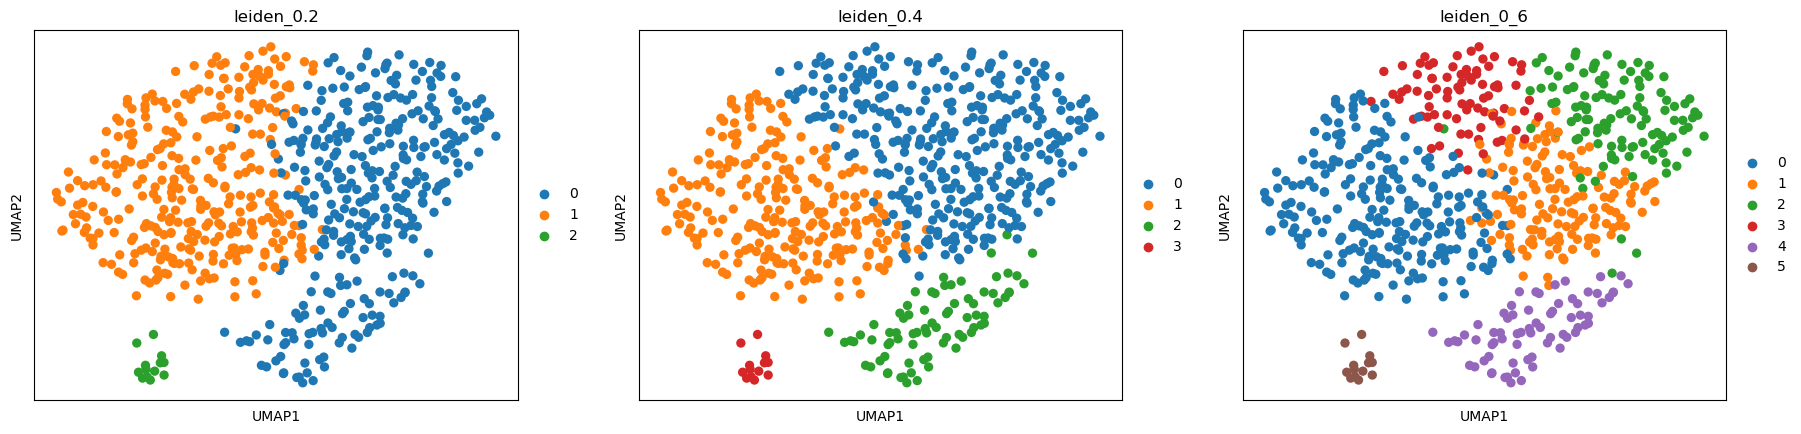

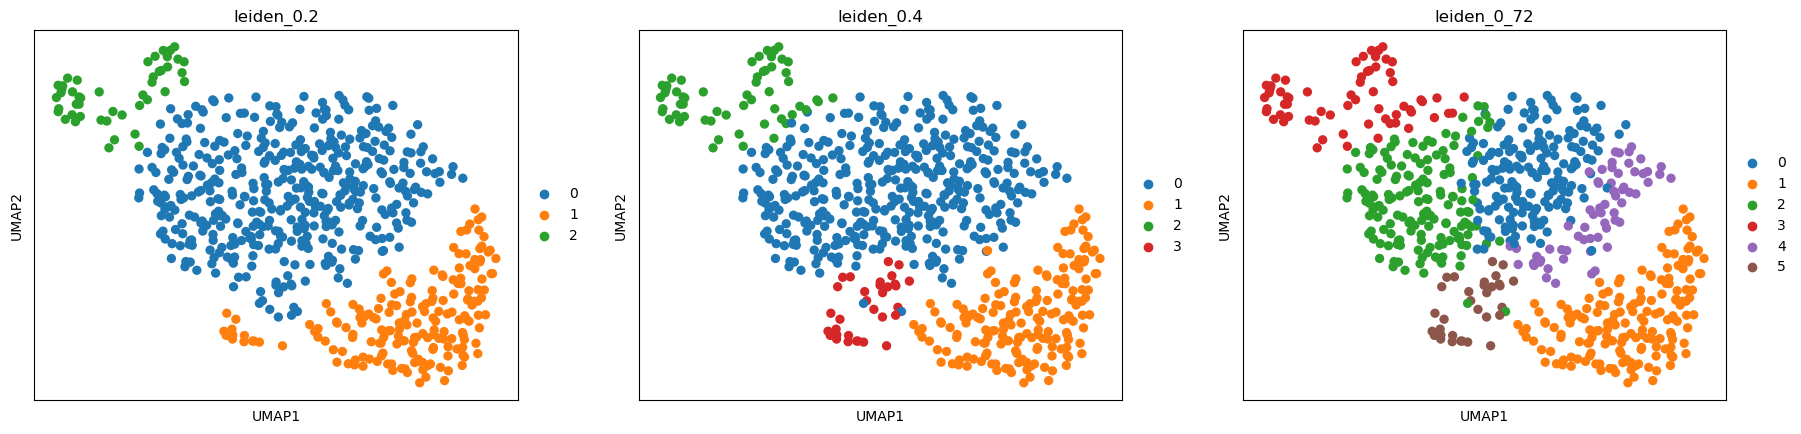

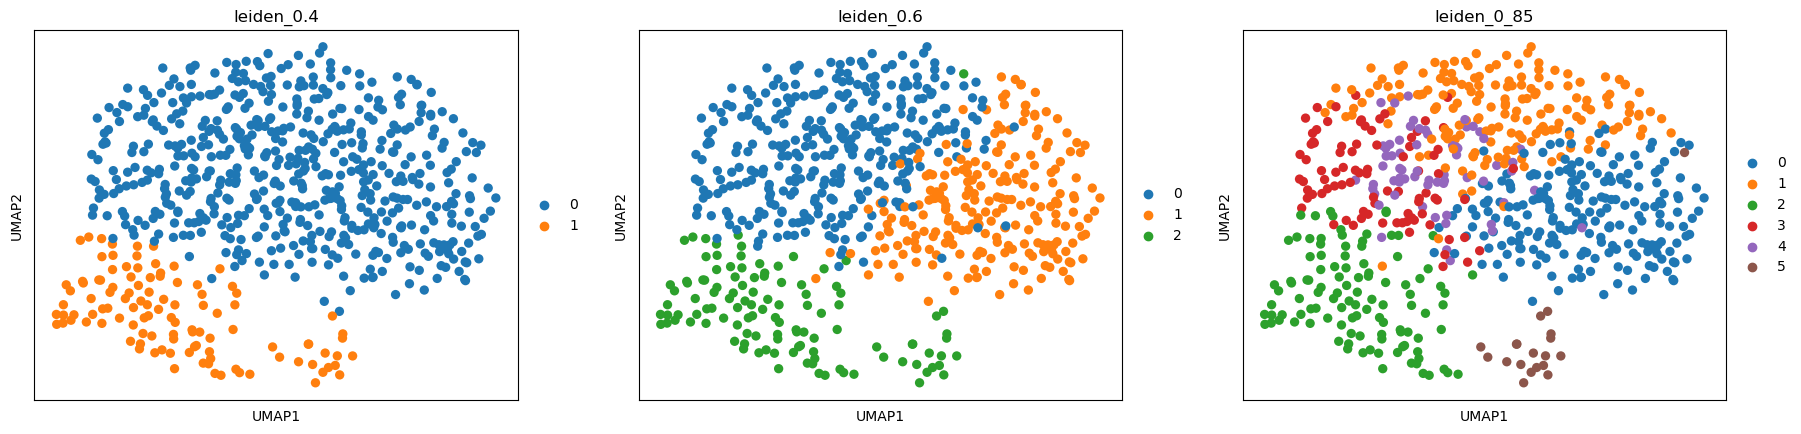

In [36]:
#Showing results in UMAPs


sc.pl.umap(adata_latent, color=['leiden_0.2', 'leiden_0.4', 'leiden_0_6'], ncols =3)
sc.pl.umap(adata_adt, color=['leiden_0.2', 'leiden_0.4', 'leiden_0_72'], ncols =3)
sc.pl.umap(adata_gex, color=['leiden_0.4', 'leiden_0.6', 'leiden_0_85'], ncols =3)

In [37]:
adata_latent

AnnData object with n_obs × n_vars = 665 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS', 'leiden_0.2', 'leiden_0.4', 'leiden_0_6'
    uns: 'neighbors', 'umap', 'leiden', 'leiden_0.2_colors', 'leiden_0.4_colors', 'leiden_0_6_colors'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_tota

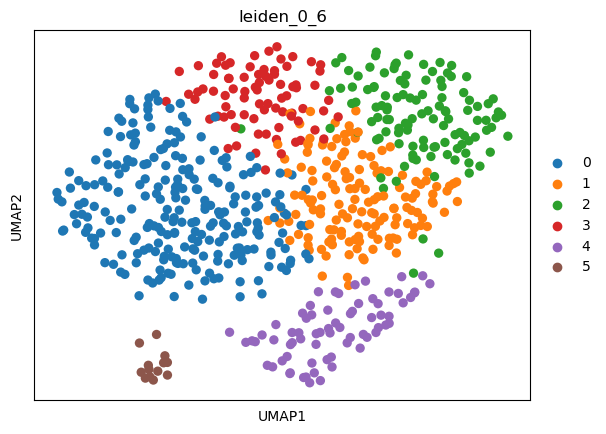

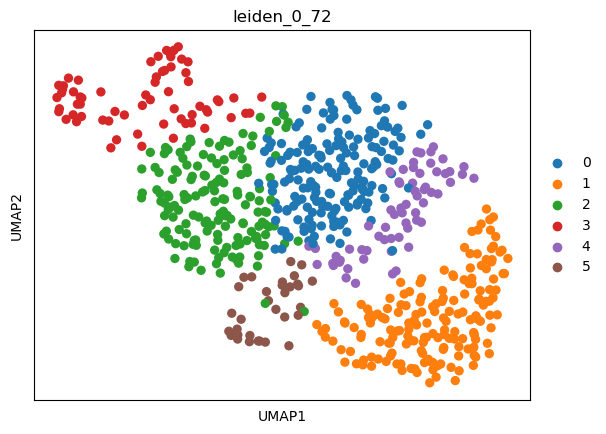

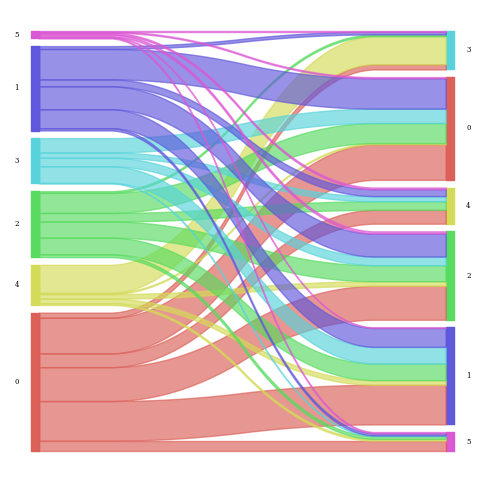

In [38]:
#Latent vs prot

sc.pl.umap(adata_latent, color=['leiden_0_6'])
sc.pl.umap(adata_adt, color=['leiden_0_72'])
sankey.sankey(adata_latent.obs.leiden_0_6, adata_adt.obs.leiden_0_72, aspect=20, fontsize=5)

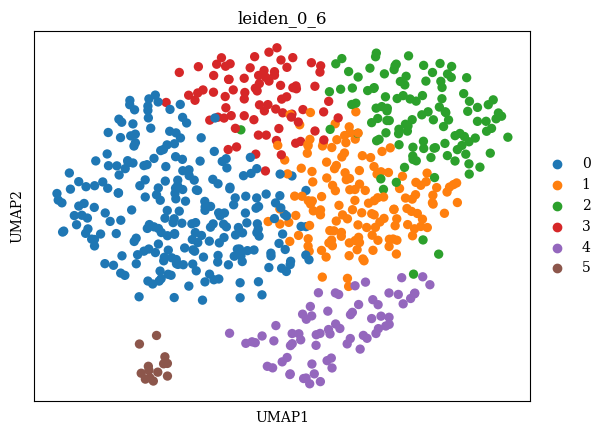

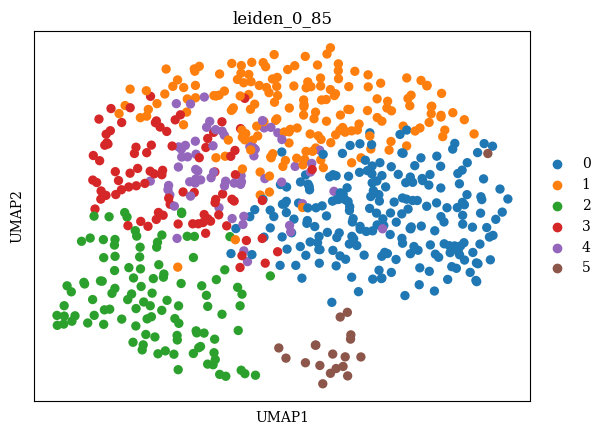

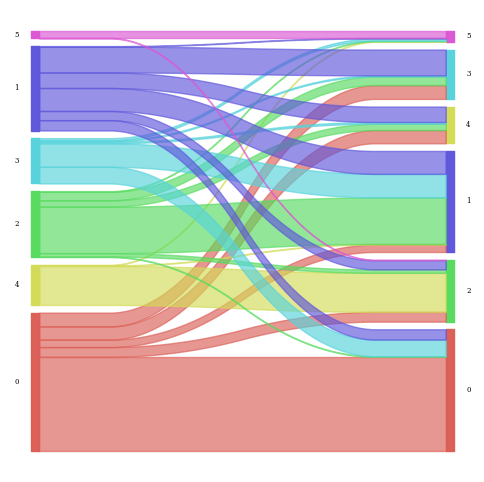

In [39]:
#Latent vs RNA

sc.pl.umap(adata_latent, color=['leiden_0_6'])
sc.pl.umap(adata_gex, color=['leiden_0_85'])
sankey.sankey(adata_latent.obs.leiden_0_6, adata_gex.obs.leiden_0_85, aspect=20, fontsize=5)

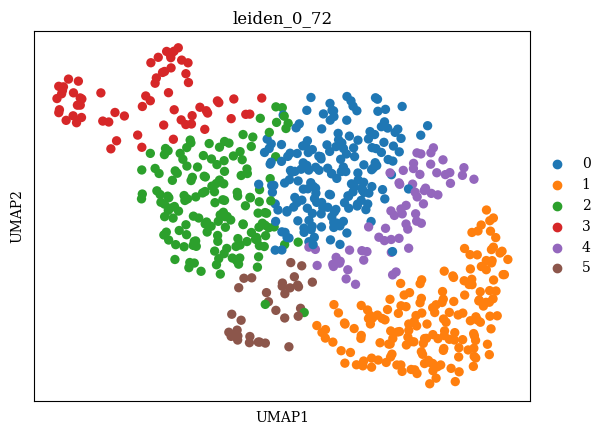

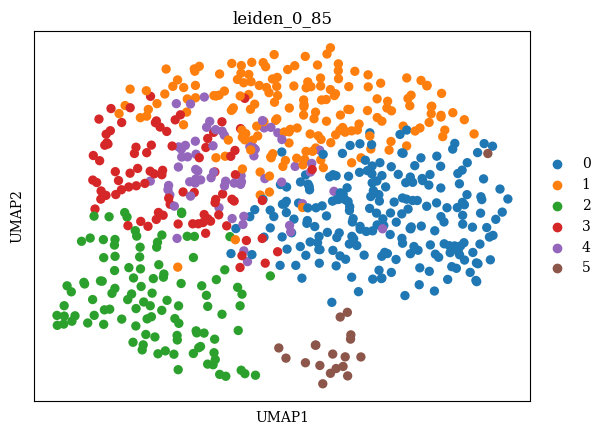

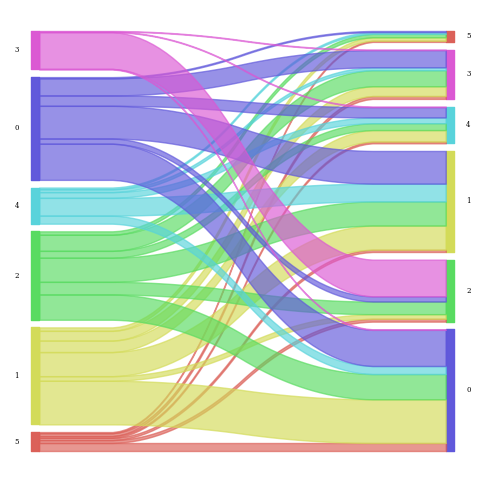

In [40]:
#prot vs rna
sc.pl.umap(adata_adt, color=['leiden_0_72'])
sc.pl.umap(adata_gex, color=['leiden_0_85'])
sankey.sankey(adata_adt.obs.leiden_0_72, adata_gex.obs.leiden_0_85, aspect=20, fontsize=5)

# Find marker genes/proteins from leiden clusters

In [41]:
#Removing MALAT1 and mito + ribo genes from adata_gex

#MALAT1 is more or less technical finding => remove

#malat1 = adata_gex.var_names.str.startswith('MALAT1')

#genes to be removed
#mito_genes = adata_gex.var_names.str.startswith('MT-')
#ribo_genes = adata_gex.var_names.str.startswith('RPL')
#ribo_genes1 = adata_gex.var_names.str.startswith('RPS')

#remove = np.add(mito_genes, malat1)
#remove = np.add(remove, ribo_genes)
#remove = np.add(remove, ribo_genes1)

#other genes kept
#keep = np.invert(remove)

#adata_gex = adata_gex[:,keep]

#print(adata_gex.n_obs, adata_gex.n_vars)

In [42]:
#Removing mito + ribo genes from adata_latent


malat1 = adata_latent.var_names.str.startswith('MALAT1')

#genes to be removed
mito_genes = adata_latent.var_names.str.startswith('MT-')
ribo_genes = adata_latent.var_names.str.startswith('RPL')
ribo_genes1 = adata_latent.var_names.str.startswith('RPS')

remove = np.add(mito_genes, ribo_genes)
remove = np.add(remove, ribo_genes1)

#other genes kept
keep = np.invert(remove)

adata_latent = adata_latent[:,keep]

print(adata_latent.n_obs, adata_latent.n_vars)

665 21604


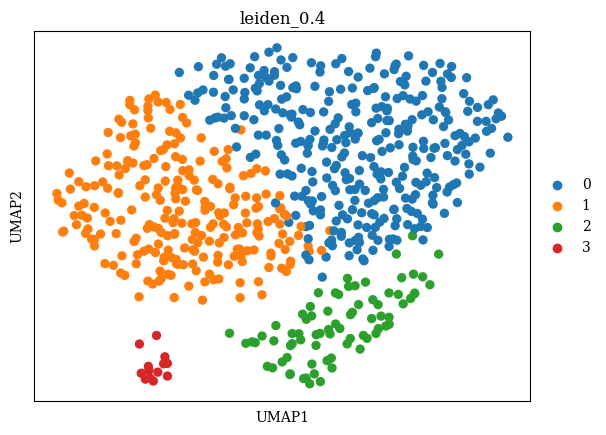

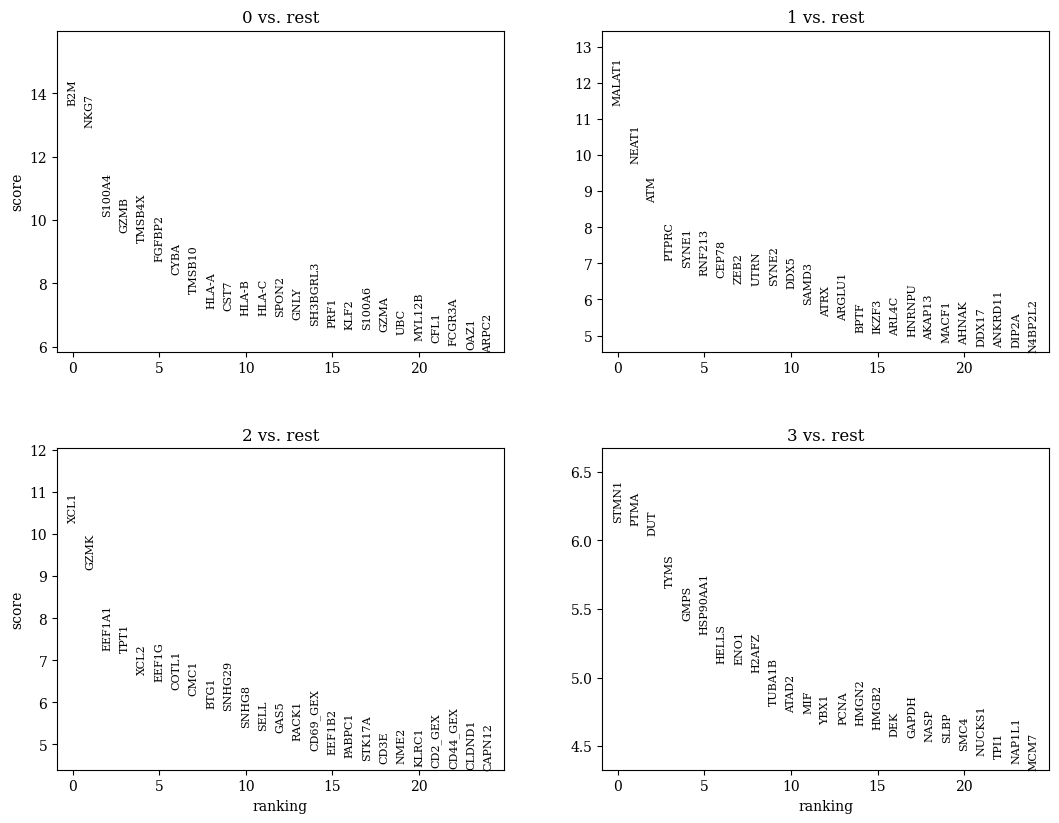

In [43]:
#Latent

sc.pl.umap(adata_latent, color=['leiden_0.4'])
sc.tl.rank_genes_groups(adata_latent, 'leiden_0.4', method='wilcoxon')
sc.pl.rank_genes_groups(adata_latent, n_genes=25, sharey=False, ncols=2)

- Cluster 0: B2M, NKG7, GZMB, PRF1 => mature CD56dim (Huuhtanen, Yang). Corrrsponds cluster 1 in s1d2. 
- Cluster 1: NEAT1 is a long-noncoding RNA. ZEB2 => Terminal NK (Yang)?  SYNE1, SYNE2 => innate immune response?
- Cluster 2: GZMK, XCL1, SELL (CD62L) => Immature CD56bright
- Cluster 3: Proliferating NK?  STM1, TYMS, HMGB2, H2FZ (Melsen). 

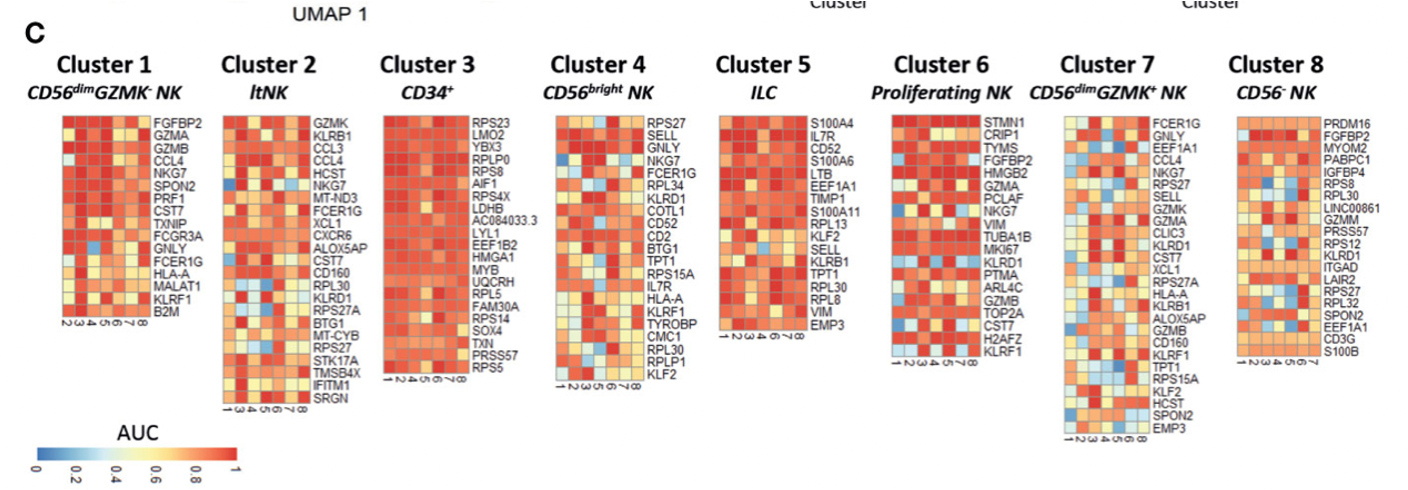
(Melsen et al. 2022)


- Clusters 1, 2, 4, 6, 7 of above figure were found also in other datasets (Crinier + Yang) 

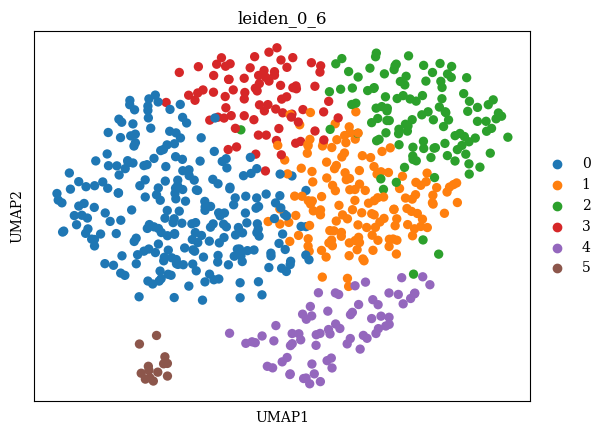

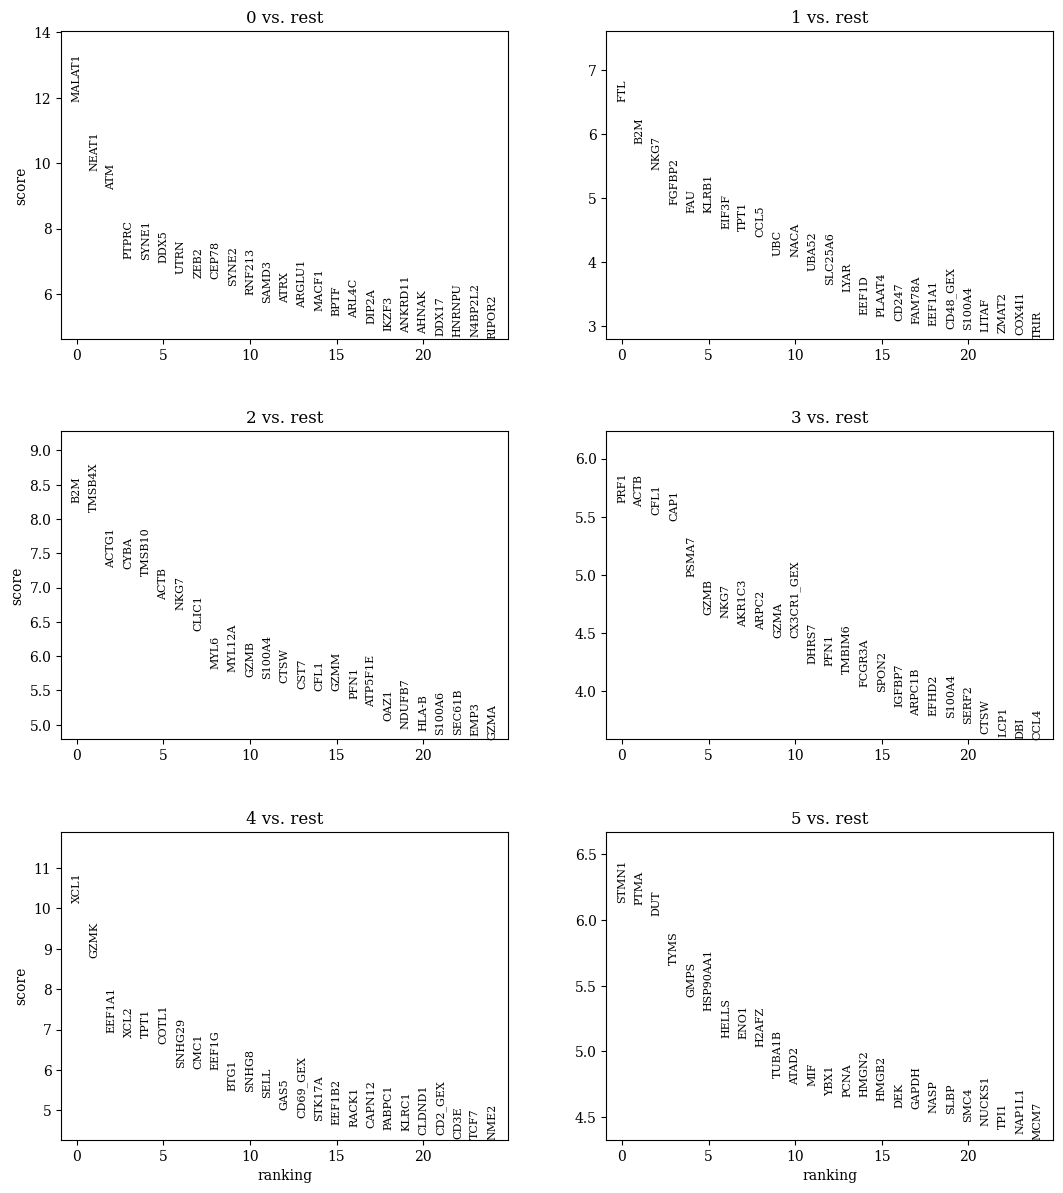

In [45]:
#Latent

sc.pl.umap(adata_latent, color=['leiden_0_6'])
sc.tl.rank_genes_groups(adata_latent, 'leiden_0_6', method='wilcoxon')
sc.pl.rank_genes_groups(adata_latent, n_genes=25, sharey=False, ncols=2)

- cluster 0: 
- Cluster 0 (mature CD56bright NKs) from previous UMAP is now divided into 3 parts (clusters 1-3). 
- Cluster 3 terminally differentiated NK? 
- Cluster 4: Immature CD56bright NK cells
- Cluster 5: Proliferating ? 

### Melsen markers

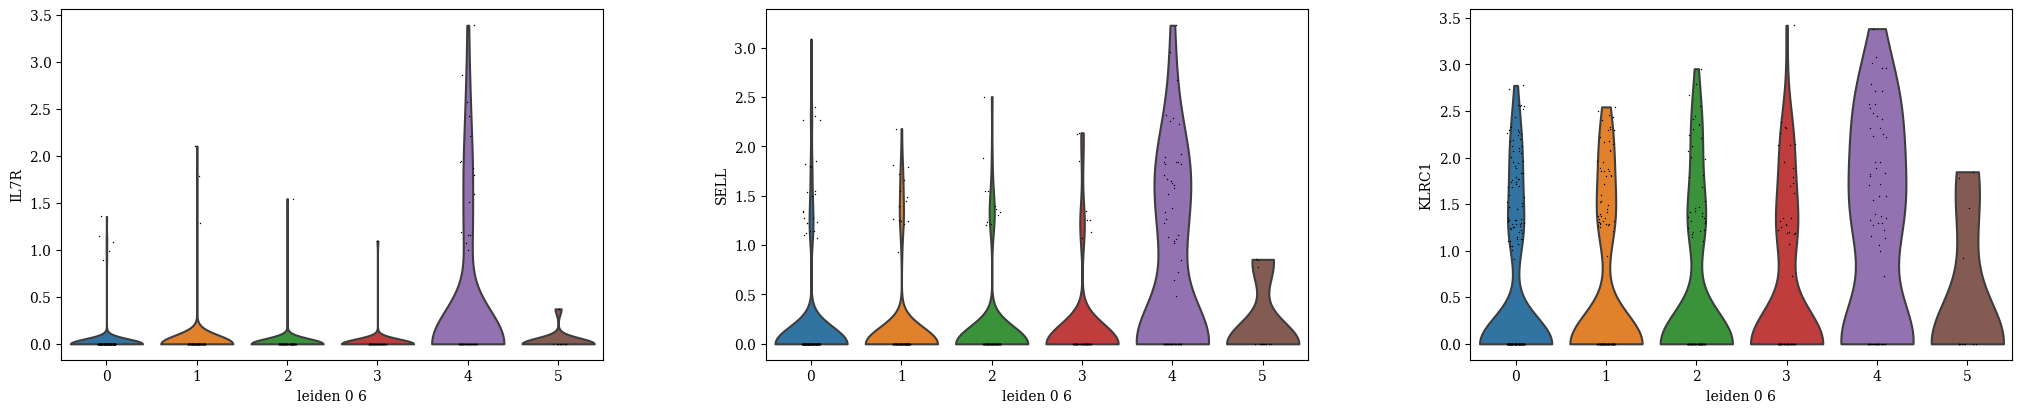

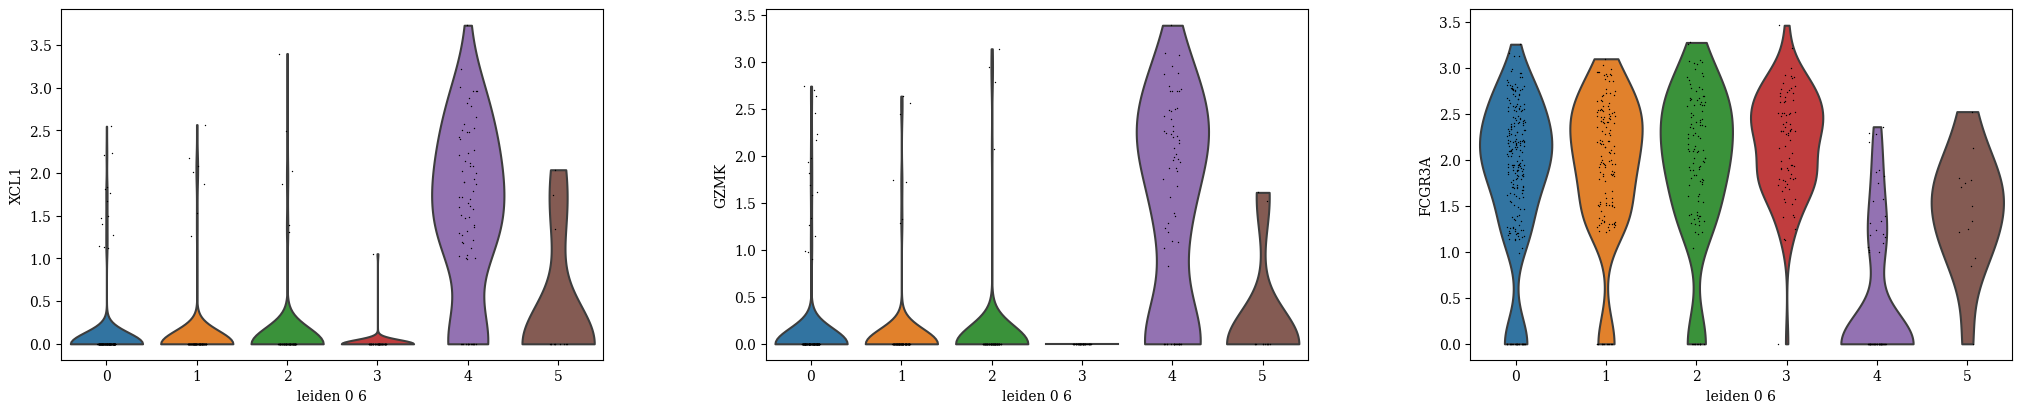

In [47]:
#Expression of genes known to be highly expressed in CD56bright NK cells (Melsen, Yang)

sc.pl.violin(adata_latent, ['IL7R', 'SELL', 'KLRC1'], groupby='leiden_0_6')

sc.pl.violin(adata_latent, ['XCL1', 'GZMK', 'FCGR3A'], groupby='leiden_0_6')

- These violinplots support the previous conclusion that cluster 4 corresbonds to immature CD56bright NK cells. 


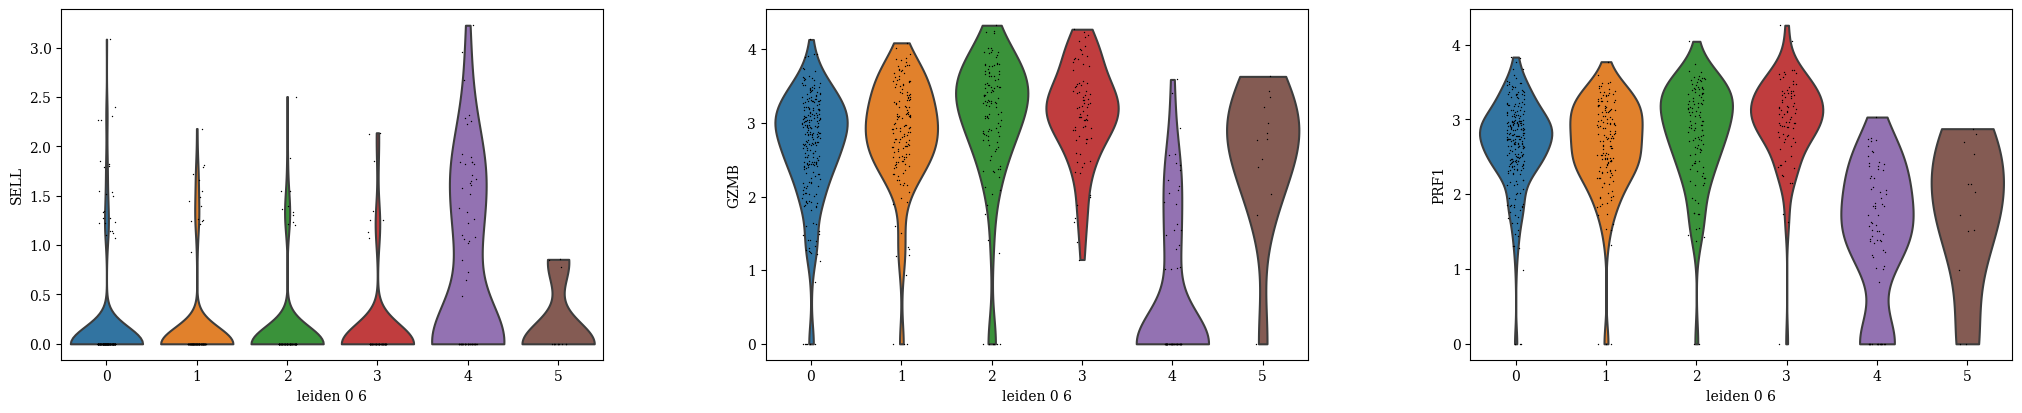

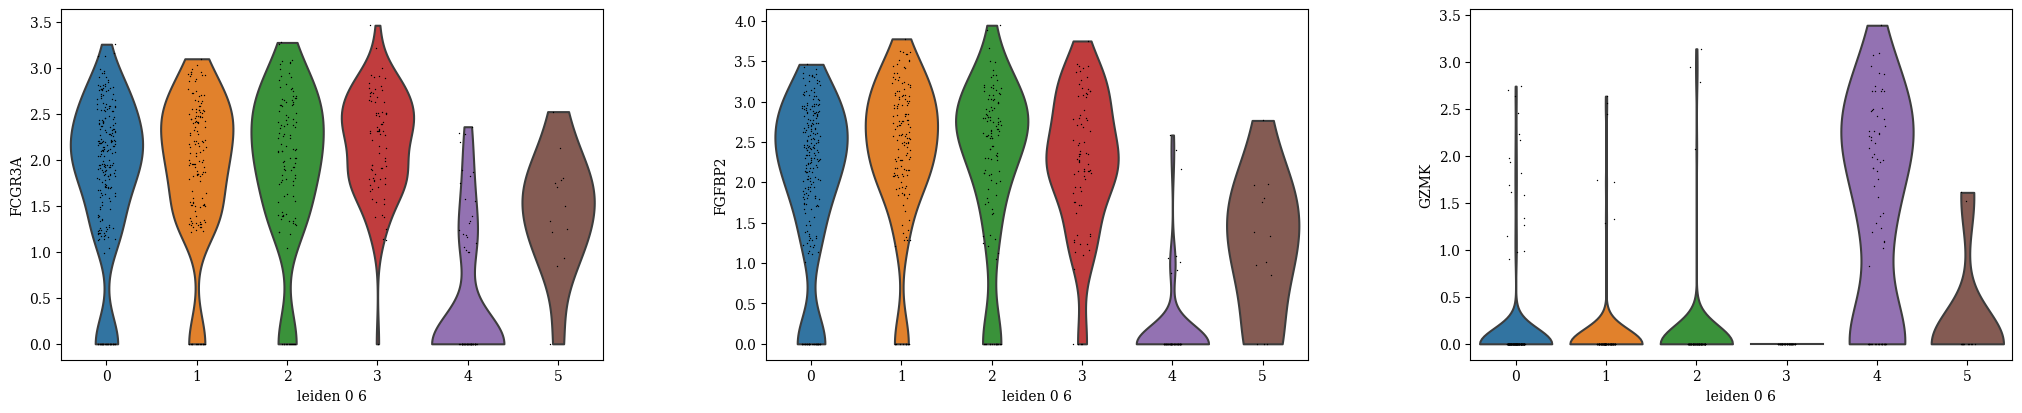

In [48]:
#CD65dim GZMK+ NK markers, transitional state between mature and immature (Melsen)

sc.pl.violin(adata_latent, ['SELL', 'GZMB', 'PRF1'], groupby='leiden_0_6')

sc.pl.violin(adata_latent, ['FCGR3A', 'FGFBP2', 'GZMK'], groupby='leiden_0_6')

According to Melsen at al. ;  "The CD56dimGZMK+ NK cells were further characterized by higher expression of SELL (CD62L), and lower expression of GZMB, PRF1 and FCGR3A (CD16) and FGFBP2 compared to CD56dimGZMK- cells"

- Here differences between clusters 0-3, which represent mature NK cells, are difficult to see. GZMB highest and GZMK lowest in cluster 3 => Terminal NKs? 

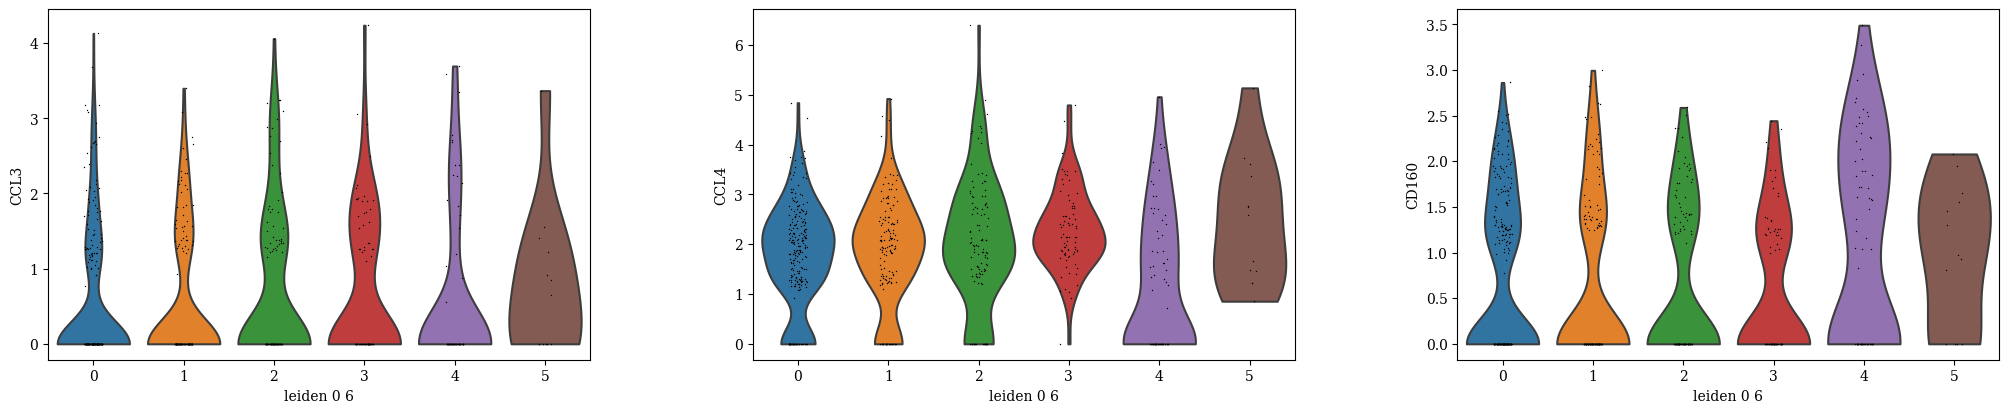

In [49]:
#Expression of genes known to be highly expressed in tissue resident ltNK (Melsen)

sc.pl.violin(adata_latent, ['CCL3', 'CCL4', 'CD160'], groupby='leiden_0_6')



- No clear ltNK corresponding cluster detected. Cluster 5 differ from others? 

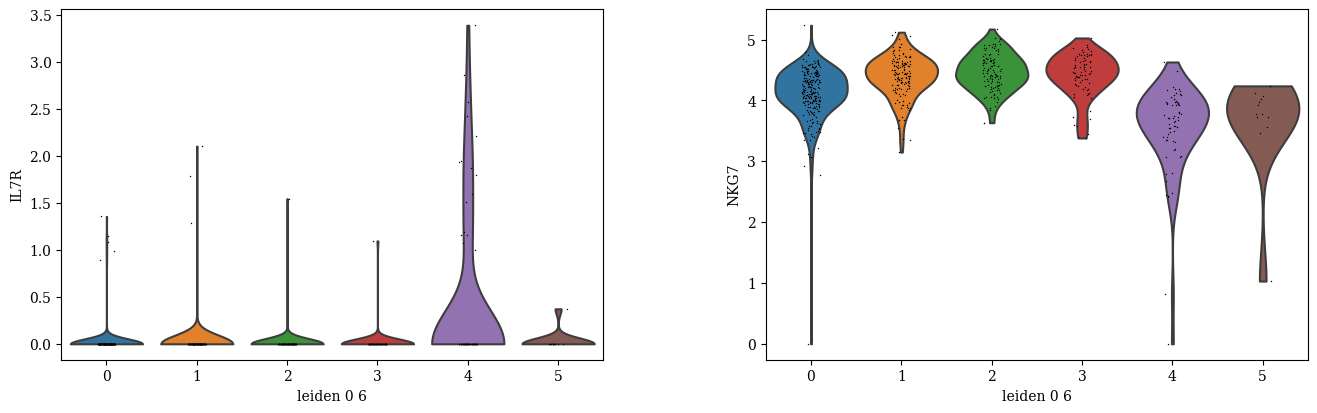

In [50]:
#ILC, high IL7R and absence of NKG7 (Melsen)

sc.pl.violin(adata_latent, ['IL7R', 'NKG7'], groupby='leiden_0_6')


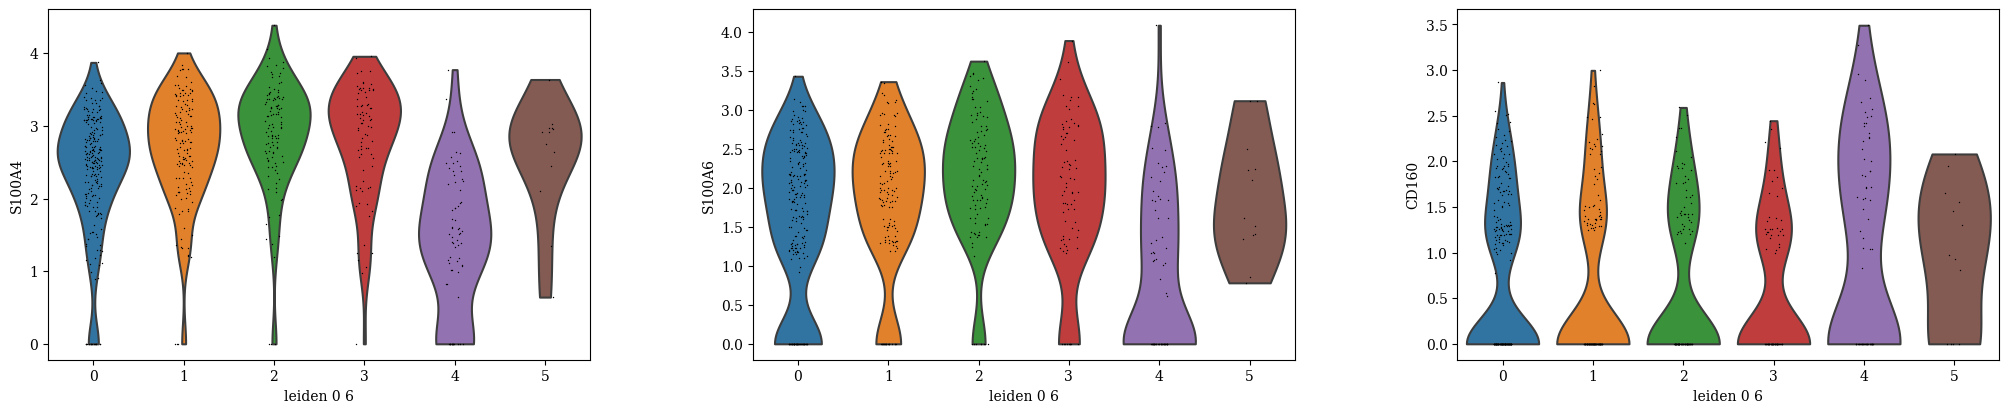

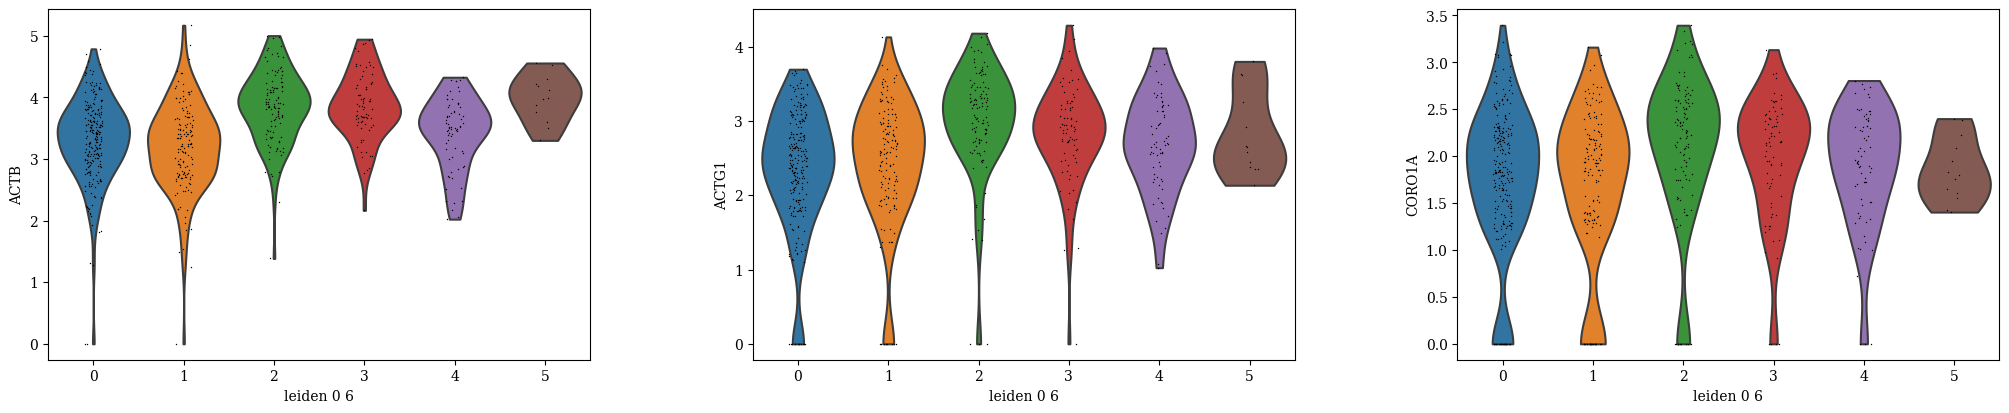

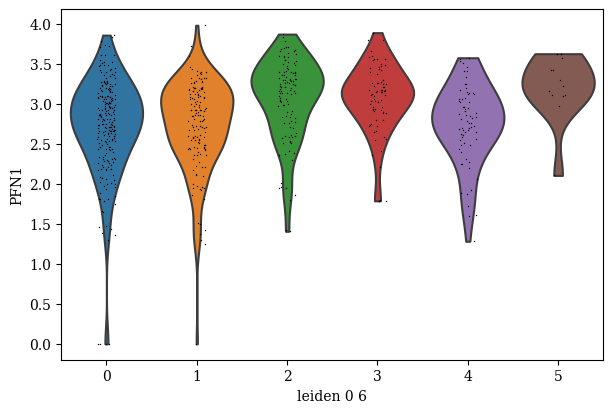

In [52]:

#Terminally differentiated NK
sc.pl.violin(adata_latent, ['S100A4', 'S100A6', 'CD160'], groupby='leiden_0_6')

#Cytoskeleton markers  => CD57+ high cytotoxicity 
sc.pl.violin(adata_latent, ['ACTB', 'ACTG1', 'CORO1A'], groupby='leiden_0_6') 
sc.pl.violin(adata_latent, ['PFN1'], groupby='leiden_0_6')


- Cluster 3 terminally differentiated? 

In [ ]:
#Adaptive-like, up regulated (Melsen)

print('Up-reg')
sc.pl.violin(adata_latent, ['KLRC2', 'IL32', 'GZMH', 'GNLY'], groupby='leiden_0.6') 

print('Down-reg')
#Adaptive-like, down regulated (Melsen)
sc.pl.violin(adata_latent, ['KLRC1', 'KLRB1', 'CD160'], groupby='leiden_0.6') 

print('Up-reg')
#Adaptive like, up regulated (Huuhtanen et al)
sc.pl.violin(adata_latent, ['CD3E', 'LAG3', 'GZMH'], groupby='leiden_0.6') 
sc.pl.violin(adata_latent, ['KLRC3', 'RHOB'], groupby='leiden_0.6')

- Here cluster 3 was GZMK-, and clusters 0,1 and 2 showed only low expression. So clusters 0-3 considered as mature CD56dim NK cells

### Yang markers

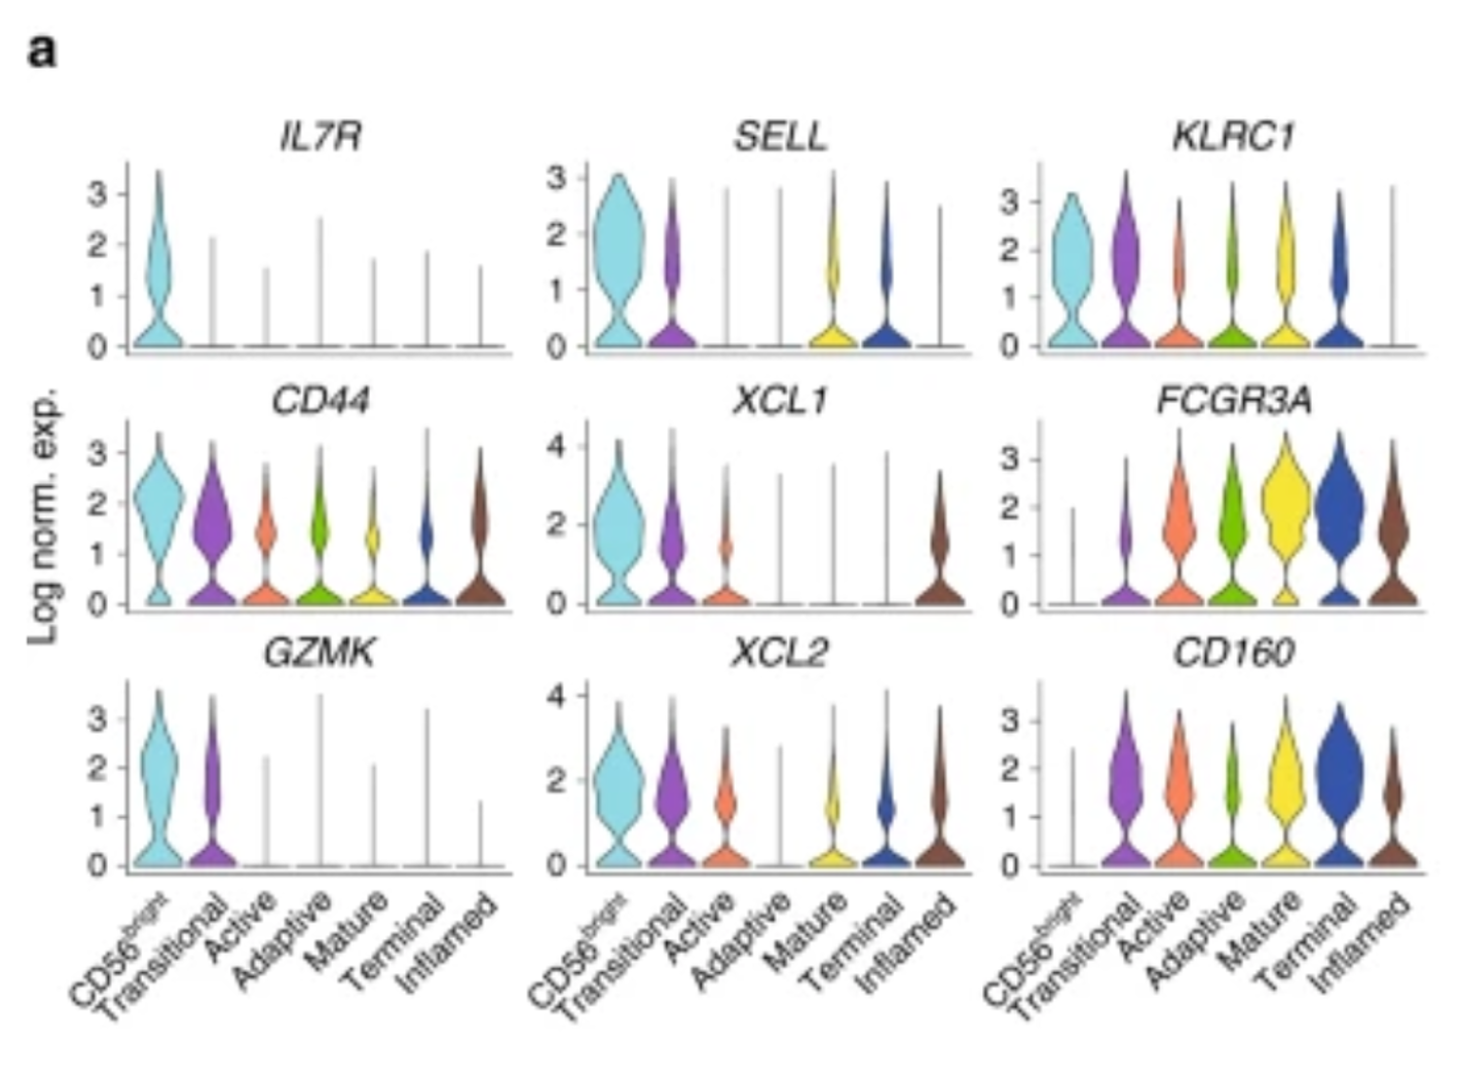


In [ ]:
#Yang, CD56bright markers

sc.pl.violin(adata_latent, ['IL7R', 'SELL', 'KLRC1'], groupby='leiden_0.6')
sc.pl.violin(adata_latent, ['CD44_GEX', 'XCL1', 'FCGR3A'], groupby='leiden_0.6')
sc.pl.violin(adata_latent, ['GZMK', 'XCL2', 'CD160'], groupby='leiden_0.6')

- Cluster 4 clearly the most immature cluster representing CD56bright NK cells. 

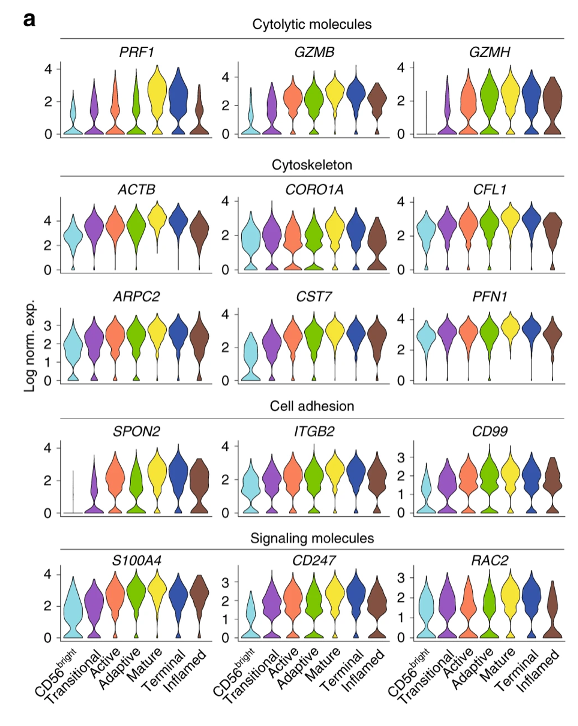


In [ ]:
#Yang, functionally mature NKs

sc.pl.violin(adata_latent, ['PRF1', 'GZMB', 'GZMH'], groupby='leiden_0.6')
sc.pl.violin(adata_latent, ['ACTB', 'CORO1A', 'CFL1'], groupby='leiden_0.6')
sc.pl.violin(adata_latent, ['ARPC2', 'CST7', 'PFN1'], groupby='leiden_0.6')
sc.pl.violin(adata_latent, ['SPON2', 'ITGB2', 'CD99'], groupby='leiden_0.6')
sc.pl.violin(adata_latent, ['S100A4', 'CD247', 'RAC2'], groupby='leiden_0.6')

In [ ]:
#Yang, terminally differentiated

sc.pl.violin(adata_latent, ['ZEB2', 'CX3CR1_GEX', 'HAVCR2'], groupby='leiden_0.6')

### Own markers

- CD56bright: High expression of  NCAM1 (CD56), IL7R, SELL (CD62L), CD44, KLRC1, XCL1 and GZMK. This was supported by minimal expression of CD57 (B3GAT1 gene expression measurement not successful?) and FCGR3A (CD16). 





In [ ]:
#CD56 bright 

sc.pl.violin(adata_latent, [ 'IL7R', 'SELL', 'CD44_GEX'], groupby='leiden_0.6')
sc.pl.violin(adata_latent, [ 'KLRC1', 'XCL1', 'GZMK'], groupby='leiden_0.6')



In [ ]:
#CD56 bright vs transitional NK

sc.pl.violin(adata_latent, ['FCGR3A'], groupby='leiden_0.6')

In [ ]:
#Active NK (Yang)

sc.pl.violin(adata_latent, ['NR4A2', 'DUSP1', 'FOSB'], groupby='leiden_0.6')

sc.pl.violin(adata_latent, [ 'FOS', 'JUN','JUNB'], groupby='leiden_0.6')



In [ ]:
#Protein

sc.pl.umap(adata_adt, color=['leiden_0_72'])
sc.tl.rank_genes_groups(adata_adt, 'leiden_0_72', method='wilcoxon')
sc.pl.rank_genes_groups(adata_adt, n_genes=25, sharey=False, ncols=2)

- Cluster 0: same as cluster 1 in s1d2 (KLRG1 top 1) 
- Cluster 1: Same as cluster 2 in s1d2 (CD158e1, CD226, CD162 high similarly) 
- Cluster 2: CD94, CD62L, CD56 => Immature CD56bright. Cluster 3 in s1d2
- Cluster 3:  ??

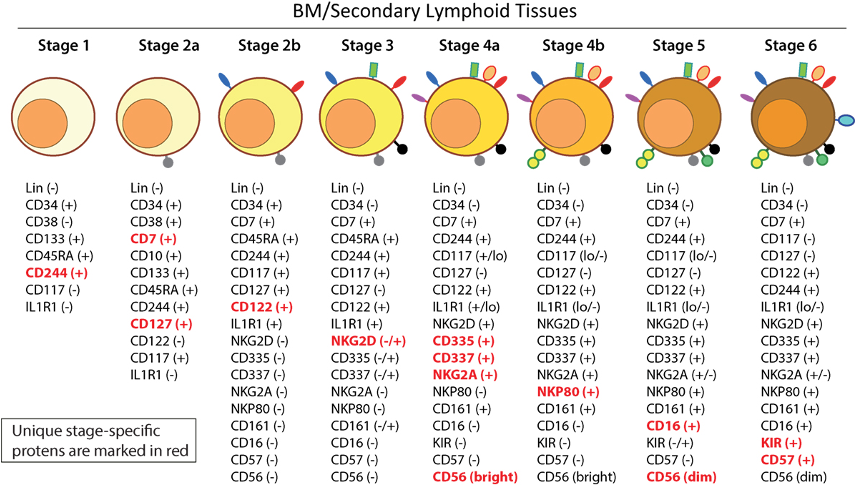

In [ ]:
#RNA

sc.pl.umap(adata_gex, color=['leiden_0.85'])
sc.tl.rank_genes_groups(adata_gex, 'leiden_0.85', method='wilcoxon')
sc.pl.rank_genes_groups(adata_gex, n_genes=25, sharey=False, ncols=2)

- Cluster 0: NKG7, B2M, GZMB => CD56dim
- Cluster 1: ZEB2, CX3CR1 => terminal NK (Yang) 
- Cluster 2: ?
- Cluster 3: XCL1, GXMK => Immature CD56bright
- Cluster 4: Same as cluster 3 in latent UMAP? 